In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
#header=None, sep=';'
yearly_df= pd.read_csv('Yearly Sunspots.csv', sep=',')

In [4]:
yearly_df.head()

,Date,Yearly Sunspot Number
0,1700/06,8.3
1,1701/06,18.3
2,1702/06,26.7
3,1703/06,38.3
4,1704/06,60.0


In [5]:
yearly_df.head()

,Date,Yearly Sunspot Number
0,1700/06,8.3
1,1701/06,18.3
2,1702/06,26.7
3,1703/06,38.3
4,1704/06,60.0


In [6]:
yearly_df['Date']=pd.to_datetime(yearly_df['Date'])

In [7]:
yearly_df=yearly_df.set_index(['Date'])

In [8]:
yearly_df.head()

,Yearly Sunspot Number
Date,
1700-06-01,8.3
1701-06-01,18.3
1702-06-01,26.7
1703-06-01,38.3
1704-06-01,60.0


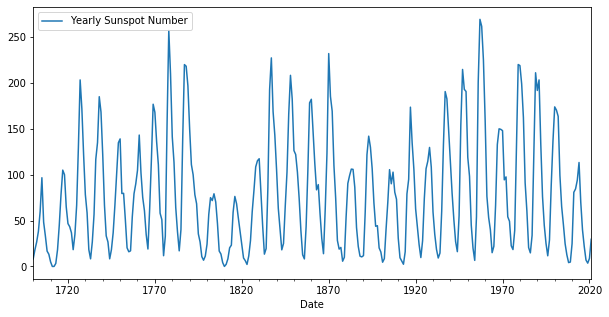

In [9]:
yearly_df.plot()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
result= adfuller(yearly_df['Yearly Sunspot Number'].dropna())
print('p-value:', result[1])

p-value: 0.026067722399238793


In [12]:
dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Test Statistic                  -3.106612
p-value                          0.026068
#Lags Used                       8.000000
Number of Observations Used    313.000000
Critical Value (1%)             -3.451416
Critical Value (5%)             -2.870819
Critical Value (10%)            -2.571714
dtype: float64


#### p-value> 0.05 indicates the time series is non-stationary

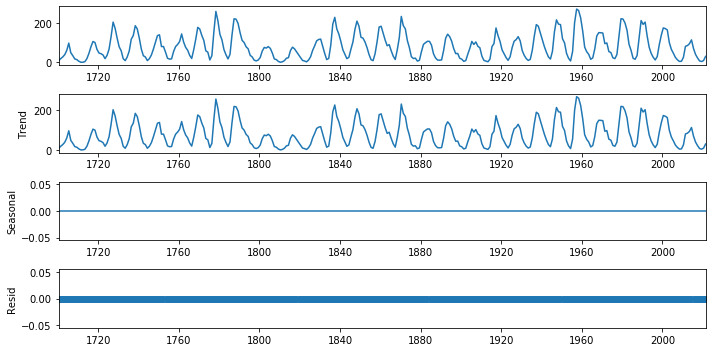

In [13]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(yearly_df,model='additive')
fig = decomposition.plot()
plt.show()

## Differencing

In [15]:
from pmdarima.arima.utils import ndiffs

In [16]:
ndiffs(yearly_df['Yearly Sunspot Number'], test="adf")

0

### Time shift

In [17]:
yearly_df['Seasonal difference']=yearly_df['Yearly Sunspot Number']- yearly_df['Yearly Sunspot Number'].shift(11)

In [18]:
yearly_df.head()

,Yearly Sunspot Number,Seasonal difference
Date,,
1700-06-01,8.3,NaN
1701-06-01,18.3,NaN
1702-06-01,26.7,NaN
1703-06-01,38.3,NaN
1704-06-01,60.0,NaN


In [19]:
adfuller(yearly_df['Seasonal difference'].dropna())[1]

0.00023927052368609856

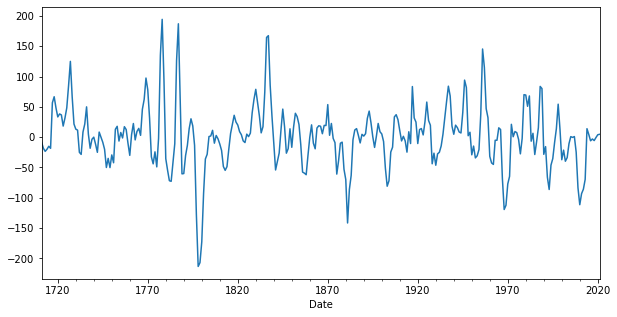

In [20]:
yearly_df['Seasonal difference'].dropna().plot()

####  After differencing once, the p-value<0.05

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

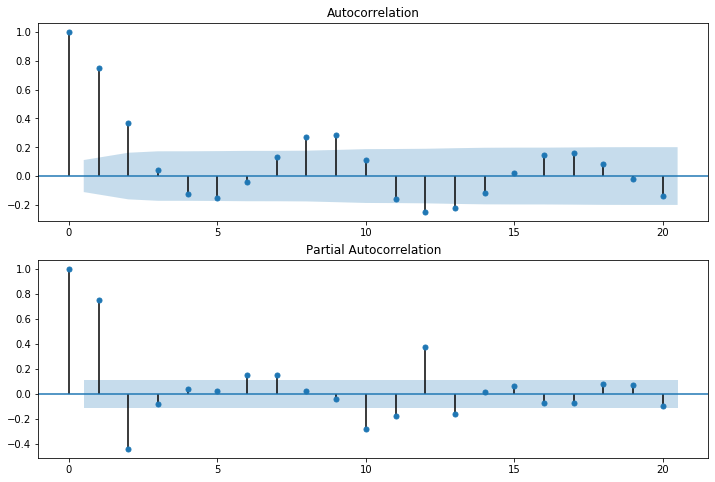

In [22]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(yearly_df['Seasonal difference'].dropna(),lags=20, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(yearly_df['Seasonal difference'].dropna(),lags=20, ax=ax2)

Till q=3, the autocorrelation is above 0.2 &
p=1 is significant

In [23]:
from scipy.signal import argrelextrema

In [24]:
lag_vals = np.arange(12*12)
autocorr_ser = np.array([yearly_df['Yearly Sunspot Number'].autocorr(lag=n) for n in lag_vals])
argrelextrema(autocorr_ser, np.less, order = 2)[0]
# we choose order = 2 because order = 1 gives two local maxima at lags = 125 and 128 months.

array([  5,  16,  27,  37,  48,  60,  71,  83,  94, 104, 115, 126, 137],
      dtype=int64)

In [25]:
ser = pd.Series(yearly_df['Yearly Sunspot Number'].values,index = yearly_df.index)

In [26]:
ser[argrelextrema(ser.values,np.less, order = 5)[0]]

Date
1723-06-01    18.3
1733-06-01     8.3
1744-06-01     8.3
1755-06-01    16.0
1766-06-01    19.0
1775-06-01    11.7
1784-06-01    17.0
1798-06-01     6.8
1810-06-01     0.0
1823-06-01     2.2
1833-06-01    13.4
1843-06-01    18.1
1856-06-01     8.2
1867-06-01    13.9
1878-06-01     5.7
1889-06-01    10.4
1901-06-01     4.6
1913-06-01     2.4
1923-06-01     9.7
1933-06-01     9.2
1944-06-01    16.1
1954-06-01     6.6
1964-06-01    15.0
1976-06-01    18.4
1986-06-01    14.8
1996-06-01    11.6
2008-06-01     4.2
2019-06-01     3.6
dtype: float64

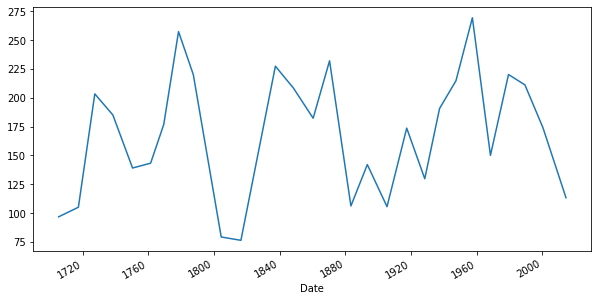

In [27]:
ser[argrelextrema(ser.values,np.greater, order = 7)[0]].plot()

## Model fitting

In [11]:
from statsmodels.tsa.arima_model import ARIMA 

In [12]:
dfp=yearly_df

In [28]:
df_train = dfp[:'1996-06-01']
df_test = dfp['1997-06-01':'2019-06-01']


In [29]:
 d = q  =range(0,2)
p=(0,1,2,6,7)

In [30]:
import itertools
ARIMA_AIC=pd.DataFrame(columns=['param', 'AIC'])
pdq=list(itertools.product(p,d,q))


In [33]:

    for param in pdq:
        try:
            mod = ARIMA(df_train['Yearly Sunspot Number'],
                                            order= param)
            results = mod.fit()
            
            print('ARIMA{} - AIC:{}'.format(param,results.aic))
            ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': results.aic}, ignore_index=True)
        except:
            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0) - AIC:3185.823931236274


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1) - AIC:2928.2847559224037
ARIMA(0, 1, 0) - AIC:2885.5544028200025
ARIMA(0, 1, 1) - AIC:2799.097148431264
ARIMA(1, 0, 0) - AIC:2871.5002001636612
ARIMA(1, 0, 1) - AIC:2771.3788936670107


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, Valu

ARIMA(1, 1, 0) - AIC:2789.733287583045
ARIMA(1, 1, 1) - AIC:2782.9578565071392
ARIMA(2, 0, 0) - AIC:2687.0975914957926


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1) - AIC:2685.1068951852103
ARIMA(2, 1, 0) - AIC:2773.204770205571


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, Valu

ARIMA(6, 0, 0) - AIC:2684.310033656834


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1) - AIC:2661.451898806888


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0) - AIC:2685.3958105069073


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1) - AIC:2650.468805393665


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 0) - AIC:2674.867761400125


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1) - AIC:2657.014960458345


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0) - AIC:2662.7569514605216


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1) - AIC:2648.690937813827


In [34]:
ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
18,"(7, 1, 1)",2648.690938
14,"(6, 1, 1)",2650.468805
16,"(7, 0, 1)",2657.014960
12,"(6, 0, 1)",2661.451899
17,"(7, 1, 0)",2662.756951
15,"(7, 0, 0)",2674.867761
11,"(6, 0, 0)",2684.310034
9,"(2, 0, 1)",2685.106895
13,"(6, 1, 0)",2685.395811
8,"(2, 0, 0)",2687.097591


In [35]:
values=ARIMA_AIC

In [36]:
file_name = "ARIMAsample.pkl"

open_file = open(file_name, "wb")
pickle.dump(values, open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print(loaded_list)

NameError: name 'pickle' is not defined

In [14]:
model=ARIMA(df_train['Yearly Sunspot Number'], order=(7,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


In [15]:
result=model.fit()

In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                               
=================================================================================
Dep. Variable:     Yearly Sunspot Number   No. Observations:                  287
Model:                        ARMA(7, 1)   Log Likelihood               -1318.507
Method:                          css-mle   S.D. of innovations             23.786
Date:                   Wed, 13 Jul 2022   AIC                           2657.015
Time:                           19:06:18   BIC                           2693.610
Sample:                       06-01-1700   HQIC                          2671.682
                            - 06-01-1986                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          77.8909     10.266      7.588      0.000      57.771      98.011
ar.L1.Yearly Sunspot Number     1.8603      0.090     20.620      0.000       1.683       2.037
ar.L2.Yearly Sunspot Number    -1.2396      0.154     -8.063      0.000      -1.541      -0.938
ar.L3.Yearly Sunspot Number     0.1302      0.149      0.876      0.381      -0.161       0.421
ar.L4.Yearly Sunspot Number     0.2621      0.144      1.823      0.068      -0.020       0.544
ar.L5.Yearly Sunspot Number    -0.1692      0.146     -1.162      0.245      -0.455       0.116
ar.L6.Yearly Sunspot Number    -0.0596      0.131     -0.456      0.648      -0.316       0.197
ar.L7.Yearly Sunspot Number     0.1715      0.065      2.637      0.008       0.044       0.299
ma.L1.Yearly Sunspot Number    -0.6588      0.075     -8.839      0.000      -0.805      -0.513
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0485           -0.0000j            1.0485           -0.0000
AR.2            0.8621           -0.5794j            1.0387           -0.0942
AR.3            0.8621           +0.5794j            1.0387            0.0942
AR.4            0.3029           -1.2919j            1.3270           -0.2133
AR.5            0.3029           +1.2919j            1.3270            0.2133
AR.6           -1.5155           -0.7937j            1.7108           -0.4232
AR.7           -1.5155           +0.7937j            1.7108            0.4232
MA.1            1.5180           +0.0000j            1.5180            0.0000
-----------------------------------------------------------------------------
"""

In [17]:
dfp=yearly_df

In [18]:
dfp['ARIMA']=result.predict(start=len(df_train),end=len(df_train)+len(df_test),dynamic=True)

In [23]:
import statsmodels.api as sm 
modelsarima=sm.tsa.statespace.SARIMAX(df_train['Yearly Sunspot Number'],
                                            order= (7,1,1),
                                           seasonal_order=(7,1,0,11),
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


In [24]:
result=modelsarima.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [25]:
dfp['SARIMA']=result.forecast(steps=2*len(df_test),dynamic=True)

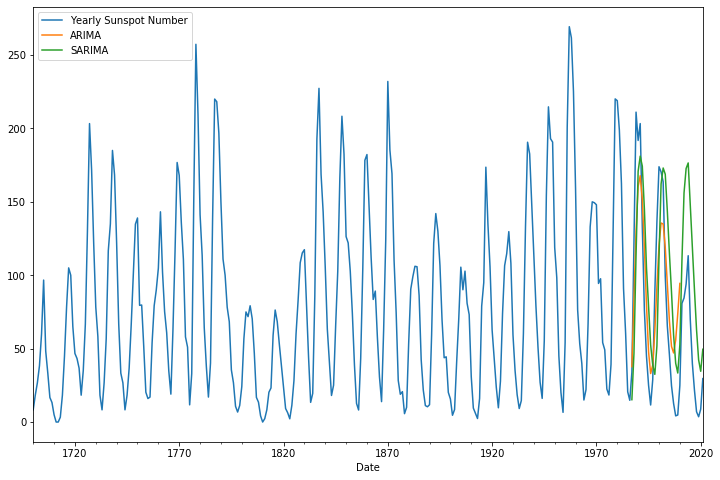

In [26]:
dfp[['Yearly Sunspot Number','ARIMA','SARIMA']].plot(figsize=(12,8))

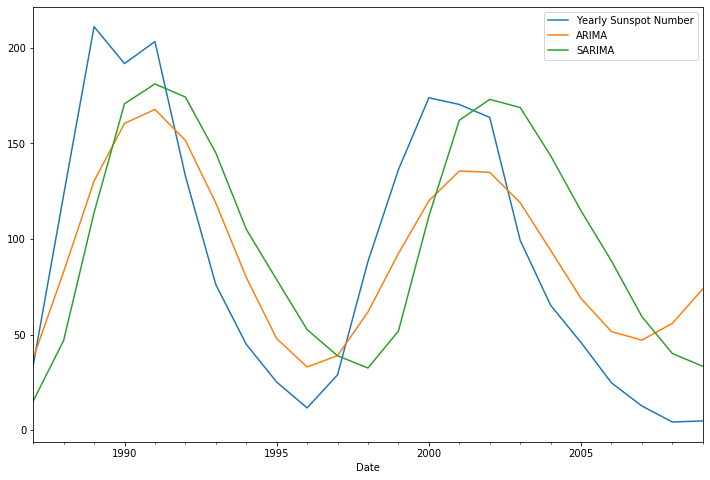

In [27]:
dfp['1987-06-01':'2010-01-01'][['Yearly Sunspot Number','ARIMA', 'SARIMA']].plot(figsize=(12,8))

### MAE

In [33]:
import sklearn.metrics
sklearn.metrics.mean_absolute_error(dfp['1987-06-01':'2010-01-01'][['Yearly Sunspot Number']], 
                                    dfp['1987-06-01':'2010-01-01'][['forecast']])

34.06969223321372

### RMSE

In [34]:
import numpy as np
np.sqrt(sklearn.metrics.mean_squared_error(dfp['1987-06-01':'2010-01-01'][['Yearly Sunspot Number']], 
                                    dfp['1987-06-01':'2010-01-01'][['forecast']]))

38.189032836126906